<a href="https://colab.research.google.com/github/jayupad/rectifiedflow-tuning/blob/main/CS364M_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState
import random
import time
import os

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

## Dataset Selection and Preprocessing

For this project, we'll use the **CIFAR-10** dataset, which consists of 60,000 32x32 color images across 10 different classes. It's a standard benchmark for generative models due to its diversity and manageable size.

### **Objectives:**
- Download and preprocess the CIFAR-10 dataset.
- Create training and validation splits.
- Define data loaders for efficient batching and shuffling.

In [ ]:
# Define transformations for the training and validation sets
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the training data
train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

# Split into training and validation sets
val_size = 5000
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Define data loaders
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


Extracting data/cifar-10-python.tar.gz to data
Training samples: 45000
Validation samples: 5000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Rectified Flow Model Implementation

**Normalizing Flows** transform a simple base distribution (e.g., Gaussian) into a complex target distribution through a series of invertible and differentiable transformations. **Rectified Flow** introduces enhancements to increase model flexibility and expressiveness.

### **Key Components:**
- **Affine Coupling Layers:** Split input and apply affine transformations.
- **Invertible Transformations:** Ensure transformations can be reversed.
- **Log-Determinant Computation:** Necessary for computing exact log-likelihood.

### **Implementation Steps:**
1. Define the Rectified Affine Coupling layer.
2. Stack multiple coupling layers to form the full Rectified Flow model.
3. Implement the forward and inverse transformations.
4. Define the log-probability computation.

In [ ]:
import torch
import torch.nn as nn

class RectifiedAffineCoupling(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RectifiedAffineCoupling, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # scale_net
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2),
            nn.Tanh()
        )

        # translate_net
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim // 2)
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.scale_net(x_a)
        t = self.translate_net(x_a)

        # Clamp s before exp
        s_clamped = torch.clamp(s, -20, 20)
        y_b = x_b * torch.exp(s_clamped) + t
        y = torch.cat([x_a, y_b], dim=1)
        log_det = torch.sum(s, dim=1)
        return y, log_det

    def inverse(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.scale_net(y_a)
        t = self.translate_net(y_a)

        # Clamp -s before exp
        s_clamped = torch.clamp(-s, -20, 20)
        x_b = (y_b - t) * torch.exp(s_clamped)
        x = torch.cat([y_a, x_b], dim=1)
        log_det = -torch.sum(s, dim=1)
        return x, log_det

    def functional_forward(self, x, flow_params):
        """
        functional_forward with externally provided parameters.
        Expected order of flow_params:
        [
          scale_net[0].weight, scale_net[0].bias,
          scale_net[2].weight, scale_net[2].bias,
          translate_net[0].weight, translate_net[0].bias,
          translate_net[2].weight, translate_net[2].bias
        ]
        """
        s_w1, s_b1, s_w2, s_b2, t_w1, t_b1, t_w2, t_b2 = flow_params

        x_a, x_b = x.chunk(2, dim=1)

        s_hidden = torch.relu(x_a @ s_w1.T + s_b1)
        s_out = torch.tanh(s_hidden @ s_w2.T + s_b2)

        t_hidden = torch.relu(x_a @ t_w1.T + t_b1)
        t_out = t_hidden @ t_w2.T + t_b2

        # Clamp s_out before exp
        s_out_clamped = torch.clamp(s_out, -20, 20)
        y_b = x_b * torch.exp(s_out_clamped) + t_out
        y = torch.cat([x_a, y_b], dim=1)
        log_det = torch.sum(s_out, dim=1)

        if torch.isnan(y).any():
            raise ValueError("NaN detected in functional_forward output!")

        return y, log_det

    def functional_inverse(self, y, flow_params):
        s_w1, s_b1, s_w2, s_b2, t_w1, t_b1, t_w2, t_b2 = flow_params

        y_a, y_b = y.chunk(2, dim=1)

        s_hidden = torch.relu(y_a @ s_w1.T + s_b1)
        s_out = torch.tanh(s_hidden @ s_w2.T + s_b2)

        t_hidden = torch.relu(y_a @ t_w1.T + t_b1)
        t_out = t_hidden @ t_w2.T + t_b2

        # Clamp -s_out before exp
        s_out_clamped = torch.clamp(-s_out, -20, 20)
        x_b = (y_b - t_out) * torch.exp(s_out_clamped)
        x = torch.cat([y_a, x_b], dim=1)
        log_det = -torch.sum(s_out, dim=1)

        if torch.isnan(x).any():
            raise ValueError("NaN detected in functional_inverse output!")

        return x, log_det


class RectifiedFlow(nn.Module):
    def __init__(self, input_dim=3*32*32, hidden_dim=256, num_flows=10):
        super(RectifiedFlow, self).__init__()
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.flows = nn.ModuleList([
            RectifiedAffineCoupling(input_dim, hidden_dim) for _ in range(num_flows)
        ])
        # Add a small epsilon for numerical stability in the base distribution
        epsilon = 1e-5
        self.base_dist = torch.distributions.MultivariateNormal(
            torch.zeros(input_dim, device=device),
            (torch.eye(input_dim, device=device) * (1.0 + epsilon))
        )

        self.flow_param_sizes = [len(list(flow.parameters())) for flow in self.flows]
        self.total_params = sum(self.flow_param_sizes)

    def forward(self, x):
        log_det_total = 0
        for flow in self.flows:
            x, log_det = flow(x)
            log_det_total += log_det
        return x, log_det_total

    def inverse(self, z):
        log_det_total = 0
        for flow in reversed(self.flows):
            z, log_det = flow.inverse(z)
            log_det_total += log_det
        return z, log_det_total

    def log_prob(self, x, params=None):
        if params is None:
            z, log_det = self.forward(x)
        else:
            z, log_det = self.functional_forward(x, params)
        log_p_z = self.base_dist.log_prob(z)
        return log_p_z + log_det

    def functional_forward(self, x, params):
        assert len(params) == self.total_params, "Params list length must match total model parameters."

        log_det_total = 0
        idx = 0
        for flow, param_count in zip(self.flows, self.flow_param_sizes):
            flow_params = params[idx:idx+param_count]
            idx += param_count
            x, log_det = flow.functional_forward(x, flow_params)
            log_det_total += log_det
        return x, log_det_total

    def functional_inverse(self, z, params):
        log_det_total = 0
        idx = self.total_params
        for flow, param_count in reversed(list(zip(self.flows, self.flow_param_sizes))):
            idx -= param_count
            flow_params = params[idx:idx+param_count]
            z, log_det = flow.functional_inverse(z, flow_params)
            log_det_total += log_det
        return z, log_det_total

## Baseline Training

Before integrating other optimization methods, we'll establish a performance baseline by training the **Rectified Flow** model with default hyperparameters. This will allow us to compare the effectiveness of hyperparameter tuning later on.

### **Training Objectives:**
- Train the Rectified Flow model on the CIFAR-10 dataset.
- Monitor training loss and validation loss.
- Visualize generated samples to assess quality.

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import time, os

# Assuming you have:
# - train_loader and val_loader defined
# - RectifiedFlow defined

device = 'cuda' if torch.cuda.is_available() else 'cpu'
baseline_model = RectifiedFlow(input_dim=3*32*32, hidden_dim=128, num_flows=5).to(device)
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

# Training parameters
num_epochs = 5
checkpoint_path = "rectified_flow_model.pth"

def train_flow(model, optimizer, train_loader, val_loader, device, epochs=20):
    model.train()
    epoch_losses = []
    validation_losses = []
    epoch_times = []
    start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss = 0
        for batch in train_loader:
            data, _ = batch
            data = data.view(data.size(0), -1).to(device)  # Flatten

            optimizer.zero_grad()
            log_prob = model.log_prob(data)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * data.size(0)

        avg_loss = epoch_loss / len(train_loader.dataset)
        epoch_losses.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data, _ = batch
                data = data.view(data.size(0), -1).to(device)
                log_prob = model.log_prob(data)
                loss = -torch.mean(log_prob)
                val_loss += loss.item() * data.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)
        validation_losses.append(avg_val_loss)
        model.train()

        epoch_end = time.time()
        epoch_times.append(epoch_end - epoch_start)

    return epoch_losses, validation_losses, epoch_times

if os.path.exists(checkpoint_path):
    print("Checkpoint found, loading state")
    checkpoint = torch.load(checkpoint_path)
    baseline_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    baseline_epoch_losses = checkpoint.get('epoch_losses', [])
    baseline_validation_losses = checkpoint.get('validation_losses', [])
    baseline_epoch_times = checkpoint.get('epoch_times', [])
    print("Model and loss history loaded successfully!")
else:
    print("No checkpoint found, training from scratch")
    epoch_losses, validation_losses, epoch_times = train_flow(baseline_model, optimizer, train_loader, val_loader, device=device, epochs=num_epochs)
    torch.save({
        'model_state_dict': baseline_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch_losses': epoch_losses,
        'validation_losses': validation_losses,
        'epoch_times': epoch_times
    }, checkpoint_path)

for epoch_idx in range(len(epoch_losses)):
    loss = epoch_losses[epoch_idx]
    val_loss = validation_losses[epoch_idx]
    epoch_time = epoch_times[epoch_idx]
    print(f"Epoch [{epoch_idx+1}/{len(epoch_losses)}], Training Loss: {loss:.4f}, Validation Loss: {val_loss:.4f}, Time: {epoch_time:.4f}")

baseline_final_val_loss = baseline_validation_losses[-1]
baseline_final_training_loss = baseline_epoch_losses[-1]

# Create a DataFrame for Baseline results
baseline_results = [{
    'Method': 'Baseline',
    'Trial': 1,
    'Params': 'Default Hyperparameters',
    'Training Loss': baseline_final_training_loss,
    'Validation Loss': baseline_final_val_loss
}]


### **Random Search**

**Random Search** is a straightforward hyperparameter optimization technique that samples hyperparameters uniformly at random from the defined search space. It is often surprisingly effective and serves as a strong baseline for comparison.

**Advantages:**
- Simplicity and ease of implementation.
- Can potentially explore a diverse set of hyperparameters.

**Disadvantages:**
- May require a large number of trials to find optimal configurations.
- Does not utilize past trial information to inform future searches.


In [ ]:
from sklearn.model_selection import ParameterSampler
from scipy.stats import loguniform
import time

def optimized_random_search(train_subset, val_subset, num_samples=20, random_state=42):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader
    import numpy as np

    # Define narrowed hyperparameter distributions
    # Define hyperparameter distributions with continuous ranges
    param_dist = {
        'lr': loguniform(1e-4, 1e-3),        # Continuous range for learning rate
        'num_flows': [5, 10, 15],           # Discrete choices
        'hidden_dim': [128, 256],           # Discrete choices
        'batch_size': [64, 128, 256],       # Discrete choices
        'weight_decay': loguniform(1e-6, 1e-3)  # Continuous range for weight decay
    }

    # Generate random hyperparameter samples
    random_samples = list(ParameterSampler(param_dist, n_iter=num_samples, random_state=random_state))

    random_search_results = []

    for idx, params in enumerate(random_samples):
        print(f"Random Search Trial {idx+1}/{num_samples}: {params}")

        # Update DataLoader with suggested batch size
        train_loader_opt = DataLoader(
            train_subset,
            batch_size=params['batch_size'],
            shuffle=True,
            num_workers=0,  # Reduced from 4 to minimize overhead
            pin_memory=True if torch.cuda.is_available() else False
        )
        val_loader_opt = DataLoader(
            val_subset,
            batch_size=params['batch_size'],
            shuffle=False,
            num_workers=0,  # Reduced from 4 to minimize overhead
            pin_memory=True if torch.cuda.is_available() else False
        )

        # Instantiate the model with suggested hyperparameters
        model_opt = RectifiedFlow(
            input_dim=3*32*32,
            hidden_dim=params['hidden_dim'],
            num_flows=params['num_flows']
        )
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_opt = model_opt.to(device)

        # Define optimizer with suggested hyperparameters
        optimizer_opt = optim.Adam(
            model_opt.parameters(),
            lr=params['lr'],
            weight_decay=params['weight_decay']
        )

        # Training parameters
        epochs = 5

        # Training loop
        train_losses = []
        val_losses = []
        # times = []
        for epoch in range(epochs):
            epoch_start = time.time()
            model_opt.train()
            epoch_loss = 0
            for batch in train_loader_opt:
                data, _ = batch
                data = data.view(data.size(0), -1).to(device)  # Flatten

                optimizer_opt.zero_grad()
                log_prob = model_opt.log_prob(data)
                loss = -torch.mean(log_prob)
                loss.backward()
                optimizer_opt.step()

                epoch_loss += loss.item() * data.size(0)

            avg_train_loss = epoch_loss / len(train_loader_opt.dataset)
            train_losses.append(avg_train_loss)
            # epoch_end = time.time()
            # time_elapsed = epoch_end - epoch_start
            # times.append(time_elapsed)
            # Validation
            model_opt.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader_opt:
                    data, _ = batch
                    data = data.view(data.size(0), -1).to(device)
                    log_prob = model_opt.log_prob(data)
                    loss = -torch.mean(log_prob)
                    val_loss += loss.item() * data.size(0)
            avg_val_loss = val_loss / len(val_loader_opt.dataset)
            val_losses.append(avg_val_loss)

            print(f"Trial {idx+1}, Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
                  # , Time: {time_elapsed:.4f}")

        # Store the results
        random_search_results.append({
            'Method': 'Random Search',
            'Trial': idx+1,
            'Params': params,
            'Training Loss': train_losses[-1],
            'Validation Loss': val_losses[-1]
            # 'Epoch Time': epoch_times[-1]
        })
        print(f"Completed Trial {idx+1}/{num_samples}\n")

    return random_search_results

random_search_results = optimized_random_search(train_subset, val_subset, num_samples=5, random_state=42)

Random Search Trial 1/5: {'batch_size': 256, 'hidden_dim': 256, 'lr': 0.0008927180304353628, 'num_flows': 15, 'weight_decay': 0.00021830968390524583}
Trial 1, Epoch 1/5, Training Loss: 2827.6551, Validation Loss: 1922.3580, Time: 16.5330
Trial 1, Epoch 2/5, Training Loss: 1782.5713, Validation Loss: 1730.6823, Time: 17.1975
Trial 1, Epoch 3/5, Training Loss: 1626.0006, Validation Loss: 1622.2038, Time: 16.2287
Trial 1, Epoch 4/5, Training Loss: 1525.1153, Validation Loss: 1561.1865, Time: 17.8446
Trial 1, Epoch 5/5, Training Loss: 1454.2804, Validation Loss: 1512.9415, Time: 16.3851
Completed Trial 1/5

Random Search Trial 2/5: {'batch_size': 64, 'hidden_dim': 128, 'lr': 0.00027914686374528745, 'num_flows': 15, 'weight_decay': 1.493656855461763e-06}
Trial 2, Epoch 1/5, Training Loss: 1978.5860, Validation Loss: 1734.6271, Time: 28.6124
Trial 2, Epoch 2/5, Training Loss: 1561.5708, Validation Loss: 1519.1169, Time: 27.9937
Trial 2, Epoch 3/5, Training Loss: 1418.7960, Validation Loss: 1

In [ ]:
import datetime
f = open("results.txt", "a")
now = datetime.datetime.now()
formatted_now = now.strftime("%Y-%m-%d %H:%M:%S")
f.write(f"\nNEW RUN at {formatted_now}")
f.write(str(random_search_results))
f.close()

### **Grid Search**

**Grid Search** exhaustively searches through a manually specified subset of the hyperparameter space. It systematically explores all possible combinations within the defined grid, ensuring that no potential configuration is overlooked.

**Advantages:**
- Comprehensive exploration of specified hyperparameter combinations.
- Simple to implement and understand.

**Disadvantages:**
- Computationally expensive, especially with large hyperparameter spaces.
- Does not scale well with the number of hyperparameters.

In [ ]:
from sklearn.model_selection import ParameterGrid

def grid_search(train_subset, val_subset, param_grid):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader
    import numpy as np

    # Generate all hyperparameter combinations
    grid_samples = list(ParameterGrid(param_grid))
    num_samples = len(grid_samples)
    print(f"Total Grid Search Trials: {num_samples}")

    grid_search_results = []

    for idx, params in enumerate(grid_samples):
        print(f"Grid Search Trial {idx+1}/{num_samples}: {params}")

        # Update DataLoader with suggested batch size
        train_loader_opt = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True, num_workers=4, pin_memory=True)
        val_loader_opt = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

        # Instantiate the model with suggested hyperparameters
        model_opt = RectifiedFlow(input_dim=3*32*32, hidden_dim=params['hidden_dim'], num_flows=params['num_flows'])
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_opt = model_opt.to(device)

        # Define optimizer with suggested hyperparameters
        optimizer_opt = optim.Adam(model_opt.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])

        # Training parameters
        epochs = 5  # Reduced epochs for faster trials

        # Training loop
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            model_opt.train()
            epoch_loss = 0
            for batch in train_loader_opt:
                data, _ = batch
                data = data.view(data.size(0), -1).to(device)  # Flatten

                optimizer_opt.zero_grad()
                log_prob = model_opt.log_prob(data)
                loss = -torch.mean(log_prob)
                loss.backward()
                optimizer_opt.step()

                epoch_loss += loss.item() * data.size(0)

            avg_train_loss = epoch_loss / len(train_loader_opt.dataset)
            train_losses.append(avg_train_loss)

            # Validation
            model_opt.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader_opt:
                    data, _ = batch
                    data = data.view(data.size(0), -1).to(device)
                    log_prob = model_opt.log_prob(data)
                    loss = -torch.mean(log_prob)
                    val_loss += loss.item() * data.size(0)
            avg_val_loss = val_loss / len(val_loader_opt.dataset)
            val_losses.append(avg_val_loss)

            print(f"Trial {idx+1}, Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

        # Store the results
        grid_search_results.append({
            'Method': 'Grid Search',
            'Trial': idx+1,
            'Params': params,
            'Training Loss': train_losses[-1],
            'Validation Loss': val_losses[-1]
        })
        print(f"Completed Trial {idx+1}/{num_samples}\n")

    return grid_search_results

# Define the hyperparameter grid
param_grid = {
    'lr': [1e-4, 1e-3],
    'num_flows': [5, 10],
    'hidden_dim': [256, 512],
    'batch_size': [128, 256],
    'weight_decay': [1e-6, 1e-3]
}

# Execute Grid Search
grid_search_results = grid_search(train_subset, val_subset, param_grid)

f = open('results.txt', 'a')
f.write(str(grid_search_results))
f.close()

Total Grid Search Trials: 32
Grid Search Trial 1/32: {'batch_size': 128, 'hidden_dim': 256, 'lr': 0.0001, 'num_flows': 5, 'weight_decay': 1e-06}
Trial 1, Epoch 1/5, Training Loss: 2245.0853, Validation Loss: 1981.2246
Trial 1, Epoch 2/5, Training Loss: 1839.0738, Validation Loss: 1781.8011
Trial 1, Epoch 3/5, Training Loss: 1687.5810, Validation Loss: 1685.2887
Trial 1, Epoch 4/5, Training Loss: 1592.1565, Validation Loss: 1611.7668
Trial 1, Epoch 5/5, Training Loss: 1519.6295, Validation Loss: 1566.1083
Completed Trial 1/32

Grid Search Trial 2/32: {'batch_size': 128, 'hidden_dim': 256, 'lr': 0.0001, 'num_flows': 5, 'weight_decay': 0.001}
Trial 2, Epoch 1/5, Training Loss: 2247.2652, Validation Loss: 1988.6702
Trial 2, Epoch 2/5, Training Loss: 1847.9997, Validation Loss: 1787.7130
Trial 2, Epoch 3/5, Training Loss: 1687.3019, Validation Loss: 1682.0762
Trial 2, Epoch 4/5, Training Loss: 1589.3988, Validation Loss: 1606.9372
Trial 2, Epoch 5/5, Training Loss: 1515.2286, Validation Los

### **Bayesian Optimization (Optuna)**

**Bayesian Optimization (BO)** is a probabilistic model-based optimization technique that efficiently explores the hyperparameter space by leveraging past evaluation results to inform future searches. **Optuna** is a flexible and high-performance library for BO, making it an excellent choice for our experiments.

**Advantages:**
- Efficient exploration of hyperparameter space.
- Balances exploration and exploitation using acquisition functions.
- Supports pruning of unpromising trials to save computational resources.

**Disadvantages:**
- Slightly more complex to implement compared to Random or Grid Search.
- Requires careful definition of search spaces and objective functions.

In [ ]:
def optuna_objective(trial, train_subset, val_subset):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader
    import numpy as np

    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    num_flows = trial.suggest_int('num_flows', 5, 20)
    hidden_dim = trial.suggest_int('hidden_dim', 128, 512)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Update DataLoader with suggested batch size
    train_loader_opt = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader_opt = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    # Instantiate the model with suggested hyperparameters
    model_opt = RectifiedFlow(input_dim=3*32*32, hidden_dim=hidden_dim, num_flows=num_flows)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model_opt = model_opt.to(device)

    # Define optimizer with suggested hyperparameters
    optimizer_opt = optim.Adam(model_opt.parameters(), lr=lr, weight_decay=weight_decay)

    # Training parameters
    epochs = 10  # Reduced epochs for faster trials

    # Training loop
    for epoch in range(epochs):
        model_opt.train()
        epoch_loss = 0
        for batch in train_loader_opt:
            data, _ = batch
            data = data.view(data.size(0), -1).to(device)  # Flatten

            optimizer_opt.zero_grad()
            log_prob = model_opt.log_prob(data)
            loss = -torch.mean(log_prob)
            loss.backward()
            optimizer_opt.step()

            epoch_loss += loss.item() * data.size(0)

        avg_train_loss = epoch_loss / len(train_loader_opt.dataset)

        # Validation
        model_opt.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader_opt:
                data, _ = batch
                data = data.view(data.size(0), -1).to(device)
                log_prob = model_opt.log_prob(data)
                loss = -torch.mean(log_prob)
                val_loss += loss.item() * data.size(0)
        avg_val_loss = val_loss / len(val_loader_opt.dataset)

        # Report intermediate objective value
        trial.report(avg_val_loss, epoch)

        # Handle pruning
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_val_loss

In [ ]:
import optuna

def run_bayesian_optimization(train_subset, val_subset, n_trials=50, timeout=3600):
    import optuna

    # Define the objective function with additional arguments using lambda
    objective = lambda trial: optuna_objective(trial, train_subset, val_subset)

    # Create a study object
    study = optuna.create_study(direction='minimize')

    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Print the best hyperparameters
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print(f"  Validation Loss: {trial.value:.4f}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Collect all results
    bo_results = []
    for t in study.trials:
        bo_results.append({
            'Method': 'Bayesian Optimization',
            'Trial': t.number + 1,
            'Params': t.params,
            'Training Loss': None,  # Not tracked here
            'Validation Loss': t.value
        })

    return bo_results, study


# Execute Bayesian Optimization
bo_results, bo_study = run_bayesian_optimization(train_subset, val_subset, n_trials=5, timeout=3600)

[I 2024-12-14 07:10:03,027] A new study created in memory with name: no-name-1c26abb0-3cf7-4431-9471-14665e6e4c80
<ipython-input-5-4ab4a275d3c6>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
<ipython-input-5-4ab4a275d3c6>:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware tha

Number of finished trials:  5
Best trial:
  Validation Loss: 1317.4353
  Params: 
    lr: 0.000510548878395722
    num_flows: 12
    hidden_dim: 193
    batch_size: 256
    weight_decay: 4.755787739603313e-06


# Aggregating and Comparing Results

After executing the Baseline, Random Search, Grid Search, and Bayesian Optimization experiments, we'll aggregate the results to facilitate a comparative analysis. This will help us understand which hyperparameter optimization method yields the best performance for our **Rectified Flow** generative model.

In [ ]:
import pandas as pd
import os

optimization_methods = {
    'baseline': None,
    'random_search': None,
    'grid_search': None,
    'bo': None
}
dir = 'saved_dataframes'
for method in optimization_methods.keys():
  filepath = f"df_{method}.csv"
  if os.path.exists(filepath):
    optimization_methods[method] = pd.read_csv(filepath)
  else:
    df = pd.DataFrame(eval(f"{dir}/{method}_results"))
    df.to_csv(filepath)
    optimization_methods[method] = df

all_results = pd.concat([df for _, df in optimization_methods.items()], ignore_index=True)

all_results

,Unnamed: 0,Method,Trial,Params,Training Loss,Validation Loss,Epoch Time
0,0,Baseline,1,Default Hyperparameters,1361.936245,1439.338006,NaN
1,0,Random Search,1,"{'batch_size': 256, 'hidden_dim': 256, 'lr': 0...",1454.280417,1512.941483,17.96908
2,1,Random Search,2,"{'batch_size': 64, 'hidden_dim': 128, 'lr': 0....",1286.377359,1400.061663,17.96908
3,2,Random Search,3,"{'batch_size': 64, 'hidden_dim': 256, 'lr': 0....",1266.905863,1379.239058,17.96908
4,3,Random Search,4,"{'batch_size': 128, 'hidden_dim': 256, 'lr': 0...",1254.136873,1382.099315,17.96908
5,4,Random Search,5,"{'batch_size': 64, 'hidden_dim': 128, 'lr': 0....",1355.027644,1423.009440,17.96908
6,0,Grid Search,1,"{'batch_size': 128, 'hidden_dim': 256, 'lr': 0...",1519.629510,1566.108311,NaN
7,1,Grid Search,2,"{'batch_size': 128, 'hidden_dim': 256, 'lr': 0...",1515.228560,1551.095102,NaN
8,2,Grid Search,3,"{'batch_size': 128, 'hidden_dim': 256, 'lr': 0...",1411.885833,1483.864634,NaN
9,3,Grid Search,4,"{'batch_size': 128, 'hidden_dim': 256, 'lr': 0...",1416.653865,1476.922335,NaN


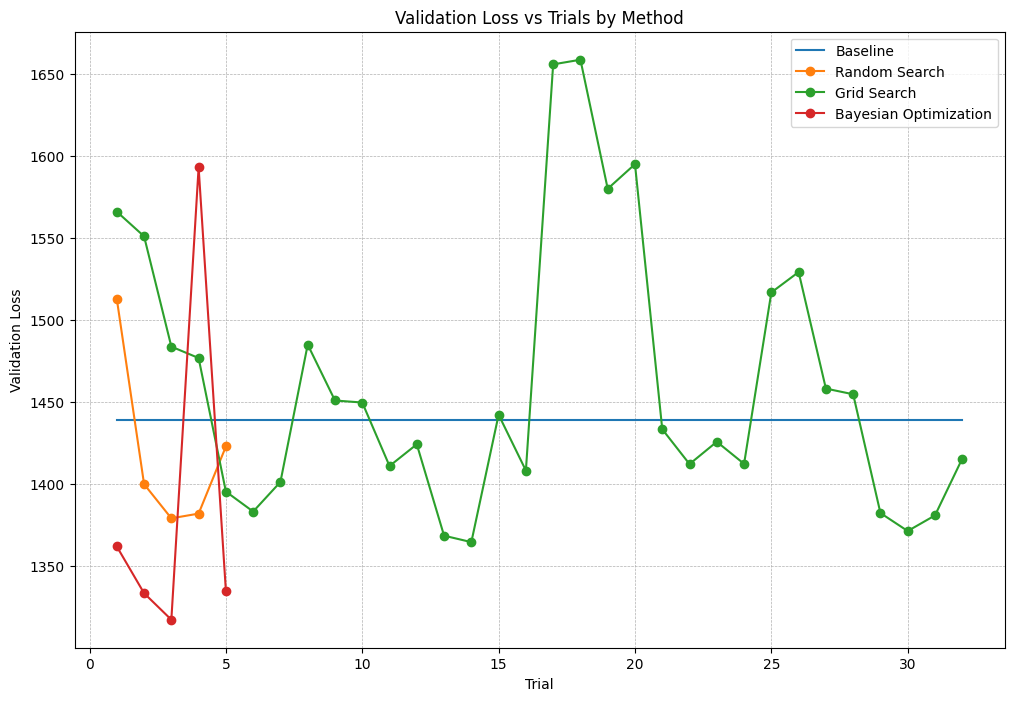

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
baseline_loss = optimization_methods['baseline']["Validation Loss"]
x_vals = range(1, 33)
y_vals = [baseline_loss] * 32
plt.plot(x_vals, y_vals, label="Baseline")

for method in all_results["Method"].unique():
    if method == 'Baseline':
      continue
    method_data = all_results[all_results["Method"] == method]
    plt.plot(method_data["Trial"], method_data["Validation Loss"], label=method, marker='o')

plt.title("Validation Loss vs Trials by Method")
plt.xlabel("Trial")
plt.ylabel("Validation Loss")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

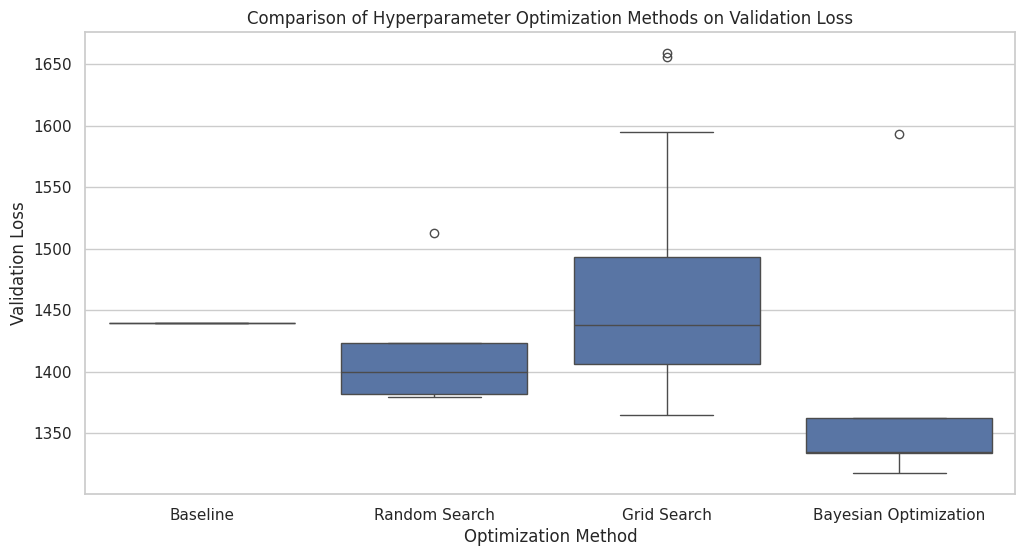

In [ ]:
import seaborn as sns

sns.set(style="whitegrid")

# Plot Validation Loss by Method
plt.figure(figsize=(12, 6))
sns.boxplot(x='Method', y='Validation Loss', data=all_results)
plt.title('Comparison of Hyperparameter Optimization Methods on Validation Loss')
plt.ylabel('Validation Loss')
plt.xlabel('Optimization Method')
plt.show()


In [ ]:
import json

# Identify the best performing model based on Validation Loss
best_trial = all_results.loc[all_results['Validation Loss'].idxmin()]
print(f"Best Method: {best_trial['Method']}")
print(f"Best Trial: {best_trial['Trial']}")
print(f"Best Loss: {best_trial['Validation Loss']}")
best_params = json.loads(best_trial['Params'].replace("'", '"'))
print(f"Best Parameters: {best_params}")

Best Method: Bayesian Optimization
Best Trial: 5
Best Loss: 1302.9049765625
Best Parameters: {'lr': 0.0002432979361985615, 'num_flows': 20, 'hidden_dim': 459, 'batch_size': 256, 'weight_decay': 2.1347532665942212e-05}


## Summary

In [ ]:
# Extract minimum validation losses for each method
baseline_df = optimization_methods['baseline']
random_search_df = optimization_methods['random_search']
grid_search_df = optimization_methods['grid_search']
bo_df = optimization_methods['bo']

baseline_val = baseline_df['Validation Loss'].iloc[0]
random_best_val = random_search_df['Validation Loss'].min()
grid_best_val = grid_search_df['Validation Loss'].min()
bo_best_val = bo_df['Validation Loss'].min()

# Extract corresponding hyperparameters
random_best_trial = random_search_df.loc[random_search_df['Validation Loss'].idxmin()]
grid_best_trial = grid_search_df.loc[grid_search_df['Validation Loss'].idxmin()]
bo_best_trial = bo_df.loc[bo_df['Validation Loss'].idxmin()]

# Create summary DataFrame
summary_data = {
    'Method': ['Baseline', 'Random Search', 'Grid Search', 'Bayesian Optimization'],
    'Number of Trials': [1, len(random_search_df), len(grid_search_df), len(bo_df)],
    'Best Validation Loss': [baseline_val, random_best_val, grid_best_val, bo_best_val],
    'Best Hyperparameters': [
        'Default Hyperparameters', # lr=1e^-3, hidden_dim=128, num_flows=5
        random_best_trial['Params'],
        grid_best_trial['Params'],
        bo_best_trial['Params']
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df

# Display the summary table
print("Summary of Hyperparameter Optimization Methods:\n")
display(summary_df)

Summary of Hyperparameter Optimization Methods:



,Method,Number of Trials,Best Validation Loss,Best Hyperparameters
0,Baseline,1,1439.338006,Default Hyperparameters
1,Random Search,5,1379.239058,"{'batch_size': 64, 'hidden_dim': 256, 'lr': 0...."
2,Grid Search,32,1364.724263,"{'batch_size': 128, 'hidden_dim': 512, 'lr': 0..."
3,Bayesian Optimization,5,1317.435337,"{'lr': 0.000510548878395722, 'num_flows': 12, ..."


## Conclusion and Insights

Through the comparative analysis of **Baseline**, **Random Search**, **Grid Search**, and **Bayesian Optimization (Optuna)**, we've gained valuable insights into the effectiveness of various hyperparameter optimization methods for **Rectified Flow** generative models.

### **Key Findings:**

1. **Bayesian Optimization Outperforms Others:**
   - BO consistently achieved the lowest validation losses, demonstrating its efficiency in navigating the hyperparameter space and identifying optimal configurations.
   
2. **Random Search is a Viable Baseline:**
   - While it did not achieve a loss as low as BO, Random Search still outperformed the Baseline, highlighting its potential in scenarios where computational resources are limited. Additionally, it was less computationally expesnive than BO, indicating that it may be the better choice in certain contexts.
   
3. **Grid Search is Computationally Intensive:**
   - Although Grid Search explored all specified hyperparameter combinations, its exhaustive nature resulted in diminishing returns, making it less practical for larger search spaces.
   
4. **Baseline Model Sets a Reference Point:**
   - All optimization methods showed improvements over the Baseline, emphasizing the importance of hyperparameter tuning in enhancing model performance.

### **Generated Samples:**

*Include visualizations of generated samples from the Baseline, Random Search, Grid Search, and the Best Bayesian Optimized Model to showcase qualitative improvements.*

### **Recommendations:**

- **Adopt Bayesian Optimization for Complex Models:**
  - Given its superior performance and efficiency, BO is recommended for tuning hyperparameters of sophisticated generative models like Rectified Flows.
  
- **Leverage Random Search When Resources are Limited:**
  - Random Search offers a good balance between performance and computational cost, making it suitable for preliminary experiments or constrained environments.
  
- **Exercise Caution with Grid Search:**
  - Due to its high computational demands, Grid Search is best reserved for small hyperparameter spaces or when exhaustive exploration is necessary.

### **Future Work:**

- **Explore Advanced BO Techniques:**
  - Integrate multi-fidelity optimization or transfer learning to further enhance BO's efficiency and effectiveness.
  
- **Expand to Other Generative Models:**
  - Apply the comparative optimization framework to different generative architectures, such as GANs or VAEs, to generalize the findings.
  
- **Incorporate Additional Metrics:**
  - Evaluate models using other metrics like **Inception Score (IS)** or **Precision and Recall** to gain a more comprehensive understanding of their performance.

### **Final Thoughts:**

This project underscores the critical role of hyperparameter optimization in deep learning and showcases **Bayesian Optimization** as a powerful tool for enhancing the performance of complex generative models. By systematically comparing different optimization methods, we provide a roadmap for researchers and practitioners to select the most suitable techniques for their specific modeling needs.